For this task, you’ll be given new data: 5 files representing trading activity in SPY for 5 different days within the time period of 2018-2021.  This is a more open-ended, exploratory task.<br> Give some summary statistics describing each days’ worth of data.<br> Investigate whatever properties of the data you find interesting.<br> Describe what you look at and what you find.<br> Do any of these days seem “unusual” in any sense compared to the others?<br> Do you think any of these might represent days that are close together in time?<br> Do you think any of these might represent days that are very far apart in time? Explain your reasoning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv('Day1_Trades_SPY.csv', parse_dates = ['Time'], index_col = 'Time')
df2 = pd.read_csv('Day2_Trades_SPY.csv', parse_dates = ['Time'], index_col = 'Time')
df3 = pd.read_csv('Day3_Trades_SPY.csv', parse_dates = ['Time'], index_col = 'Time')
df4 = pd.read_csv('Day4_Trades_SPY.csv', parse_dates = ['Time'], index_col = 'Time')
df5 = pd.read_csv('Day5_Trades_SPY.csv', parse_dates = ['Time'], index_col = 'Time')

### 1. Summary statistics for each day. Initial assumptions
##### Doing it manuallly instead of using the describe method to save some screen space and only show the basic metrics we are interested in

In [3]:
# create a list of all dataframes
dfs = [df1,df2,df3,df4,df5]

# print descriptive statistics for each day
for num, d in enumerate(dfs,1):
    print(
        f"Day#{num} #trades: {d['PRICE'].count(): 8}\
        AVG Price: {int(d['PRICE'].mean())}\
        Med Price: {int(d['PRICE'].median())}\
        AVG Size: {int(d['SIZE'].mean()): 4}\
        Med Size: {int(d['SIZE'].median()): 4}\n")

Day#1 #trades:   342068        AVG Price: 457        Med Price: 457        AVG Size:  111        Med Size:  100

Day#2 #trades:   314071        AVG Price: 264        Med Price: 264        AVG Size:  220        Med Size:  100

Day#3 #trades:   270851        AVG Price: 266        Med Price: 266        AVG Size:  220        Med Size:  100

Day#4 #trades:  2803902        AVG Price: 236        Med Price: 237        AVG Size:   96        Med Size:   85

Day#5 #trades:   231404        AVG Price: 442        Med Price: 442        AVG Size:  119        Med Size:  100



#### Using the basic info above we could make several assumptions for further investigation:
##### 1.1 Days #1 and #5 could be grouped based on a similar average price (442-457). Same goes for days #2 and #3 (264-266). 
##### 1.2 Days #2 and #3 have a much higher average size compared to the median size, which indicates presense of high outliers.
##### 1.3 Number of trades recorded on day #4 is much higher compared to other days.

<!-- ![image.png](attachment:image.png) -->


In [4]:
# index column has today's date in it even though the original data did not have it
# we'll keep it for the ease of plotting time series 

# create a date counter to differentiate between different datasets
day = 1
for d in dfs:
    # calculate the amount of time for each transaction in microseconds
    d['transaction_time_us'] = (pd.to_datetime(d.index, format = '%H:%M:%S.%f') - pd.to_datetime(d['PARTICIPANT_TIME'])).astype('timedelta64[us]')
    # calculate traded volume and add as a column
    d['Volume'] = d['PRICE'] * d['SIZE']
    # add column for the day to differentiate between different datasets
    d['dt'] = day
    # make it categorical
    d['dt'] = d['dt'].astype("category")
    # increment day counter
    day += 1

# concatenating the dataframes into one for ease of manipulation
df = pd.concat(dfs)
df.EXCHANGE = df.EXCHANGE.astype('category')
df.dt = df.dt.astype('category')
df['EXHANGE_TIME'] = pd.to_datetime(df.index, format = '%H:%M:%S.%f').time
df.reset_index(drop=True, inplace = True)

### 2. Plotting side by side bar charts for the number of trades by exchange with groups of days identified in # 1.1
#### We could see that distributions of trades by different exchanges on days #2 and #3 look very similar:
* on both days there were no trades recorded on exchanges C, H, N, and U
* on both days most of the trades occured on Exchanges P,T,D, and Z
* the rest of the exchanges have a similar pattern of distributions 

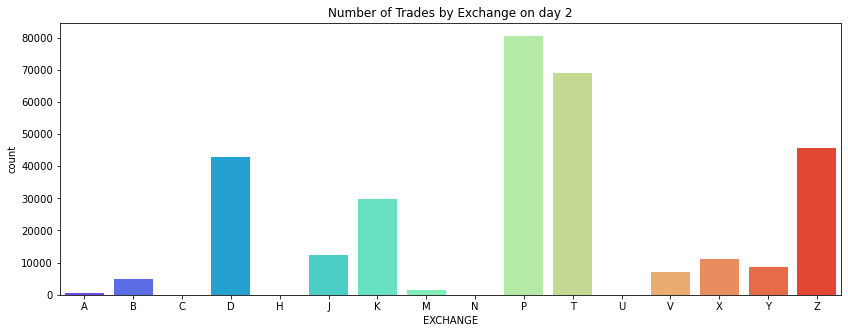

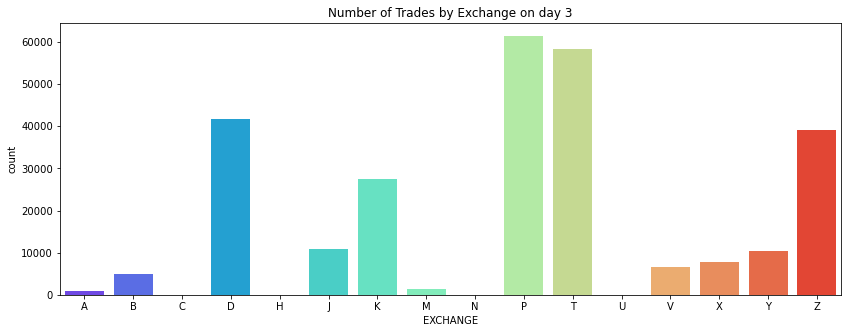

In [5]:
for dt in [2,3]:  
    plt.figure(figsize=(14,5))
    sns.countplot(
        data=df[df['dt']==dt],
        x = "EXCHANGE",
        palette='rainbow').set(title=f'Number of Trades by Exchange on day {dt}')

#### Similarly, days 1 and 5 also look alike, as you could see in the below charts:
* Exchange M was responsible for the lowest number of trades
* The rest of the exchanges had somewhat similar distributions, however, the number of trades on most of the exchanges on day 1 was higher, so it is possible that days #1 and #5 weren't necessarily immediately close to each other.

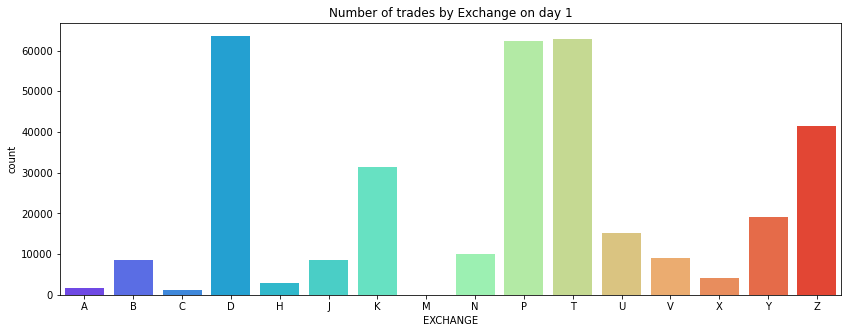

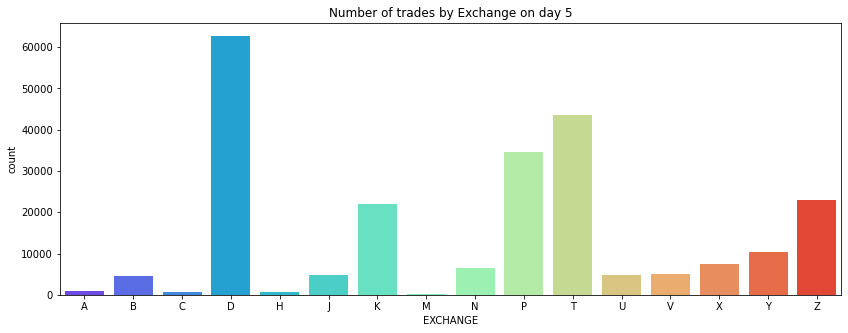

In [6]:
for dt in [1,5]:  
    plt.figure(figsize=(14,5))
    sns.countplot(
        data=df[df['dt']==dt],
        x = "EXCHANGE",
        palette='rainbow').set(title=f'Number of trades by Exchange on day {dt}')

### 3. Checking average size on days #2 and #3 to see if the assumption 1.2 that high outliers on Exchange M were dragging the average size up.


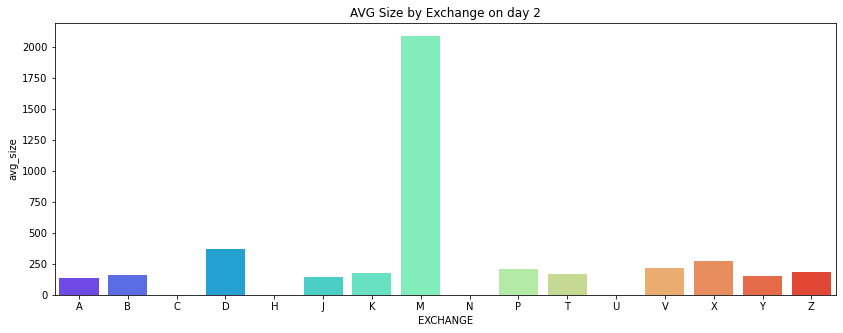

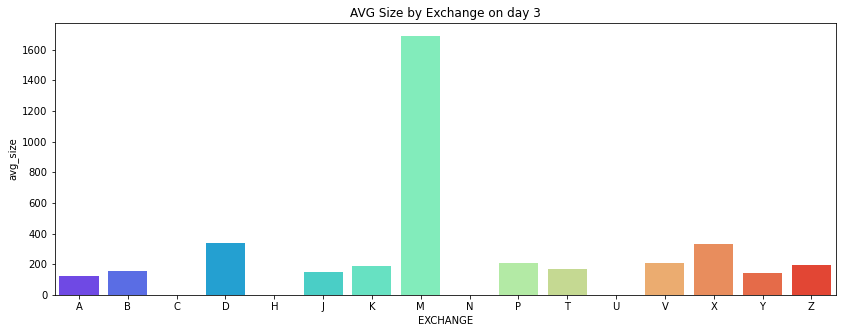

In [7]:
#calculate average size by date and Exchange 
df_by_ex = df.groupby(['dt','EXCHANGE']).agg({'SIZE':np.mean})
df_by_ex.rename(columns = {'SIZE': 'avg_size'}, inplace = True)
df_by_ex.reset_index(inplace = True)
# create barcharts for days 2 and 3
for dt in [2,3]:  
    plt.figure(figsize=(14,5))
    sns.barplot(
        data=df_by_ex[df_by_ex['dt']==dt],
        x = "EXCHANGE",
        y = 'avg_size',
        palette='rainbow').set(title=f'AVG Size by Exchange on day {dt}')

#### As expected, the average trade size on exchange M was significantly higher than anywhere else on days #2 and #3. Also checking days 1 and 5 but the average sizes there look normal:

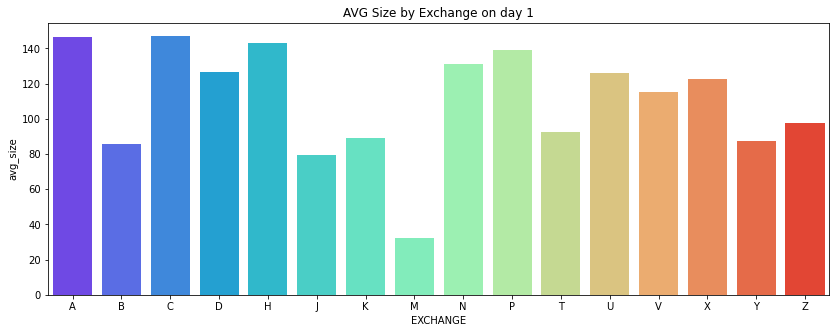

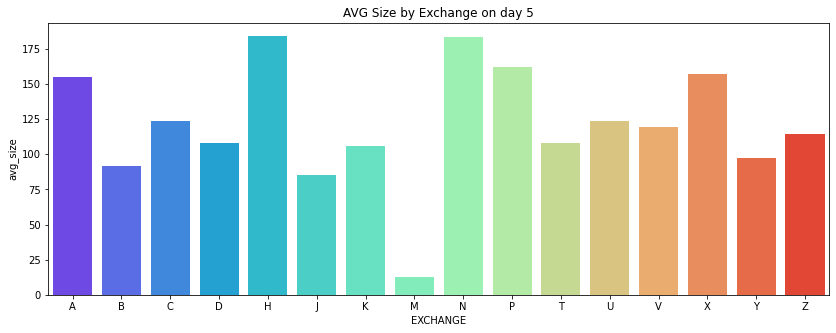

In [8]:
for dt in [1,5]:  
    plt.figure(figsize=(14,5))
    sns.barplot(
        data=df_by_ex[df_by_ex['dt']==dt],
        x = "EXCHANGE",
        y = 'avg_size',
        palette='rainbow').set(title=f'AVG Size by Exchange on day {dt}')

### 4. Using boxplots to visualize distribution of price by exchange for each day (with groups identified in # 1.2)

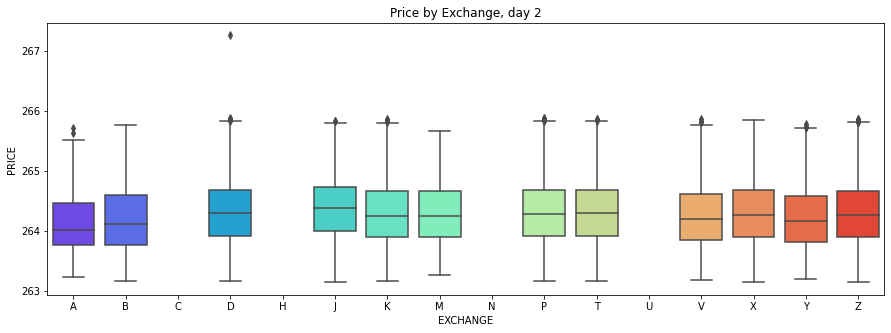

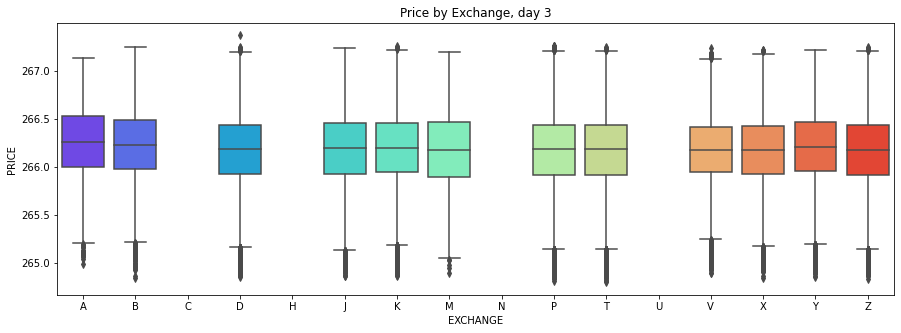

In [9]:
# checking distributions of prices on days #2 and #3
for dt in [2,3]:
    plt.figure(figsize=(15,5))
    sns.boxplot(x='EXCHANGE',y='PRICE',data=df[df['dt']==dt], palette='rainbow')
    plt.title(f"Price by Exchange, day {dt}")

#### INSIGHT: 
Median price on day #2 and #3 are close (with day #3 being slightly higher across all exchanges), which may serve as another indicator that these two days were close to each other in time. Interestingly, all of the outliers on day #2 were distributed close to the max prices, while on day #3 they were on the opposite side of the distribution, close to the minimum values

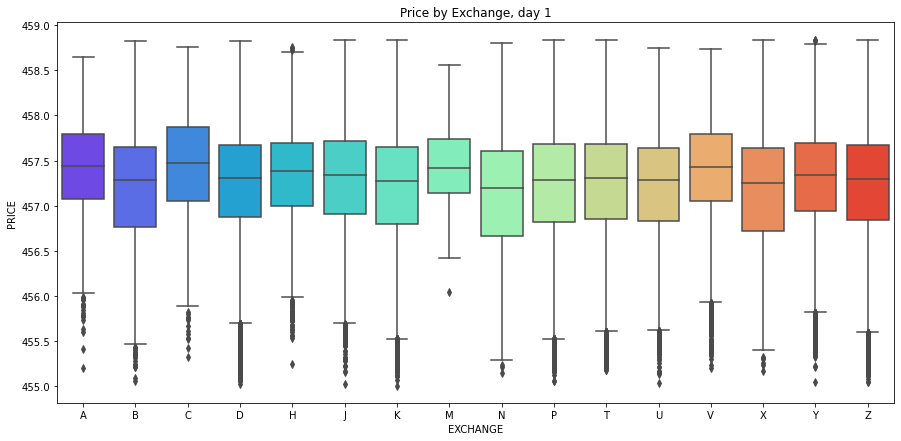

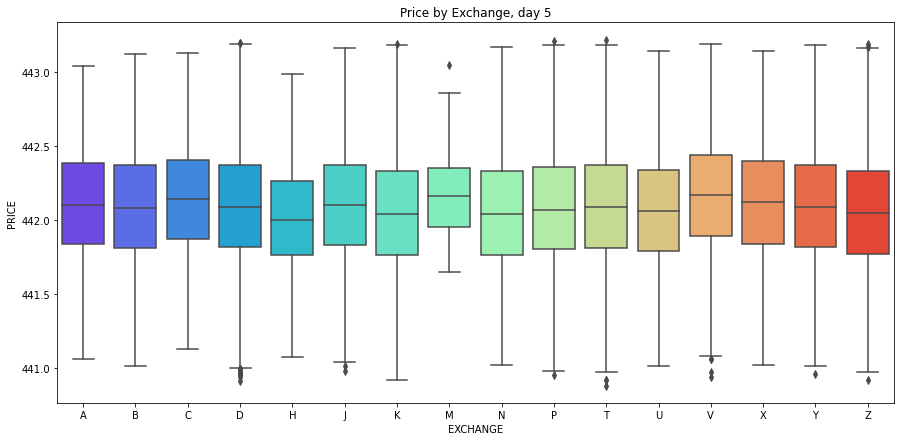

In [10]:
for dt in [1,5]:
    plt.figure(figsize=(15,7))
    sns.boxplot(x='EXCHANGE',y='PRICE',data=df[df['dt']==dt], palette='rainbow')
    plt.title(f"Price by Exchange, day {dt}")

#### INSIGHT:
Median prices on day #1 and #5 are also close but not as close as in the previous pair of days, which may indicate that these two days were further apart from each other in time.

### 5. Plotting number of trades for each day as a time series 
Resample the dataset at 15min frequency to  spot major trends

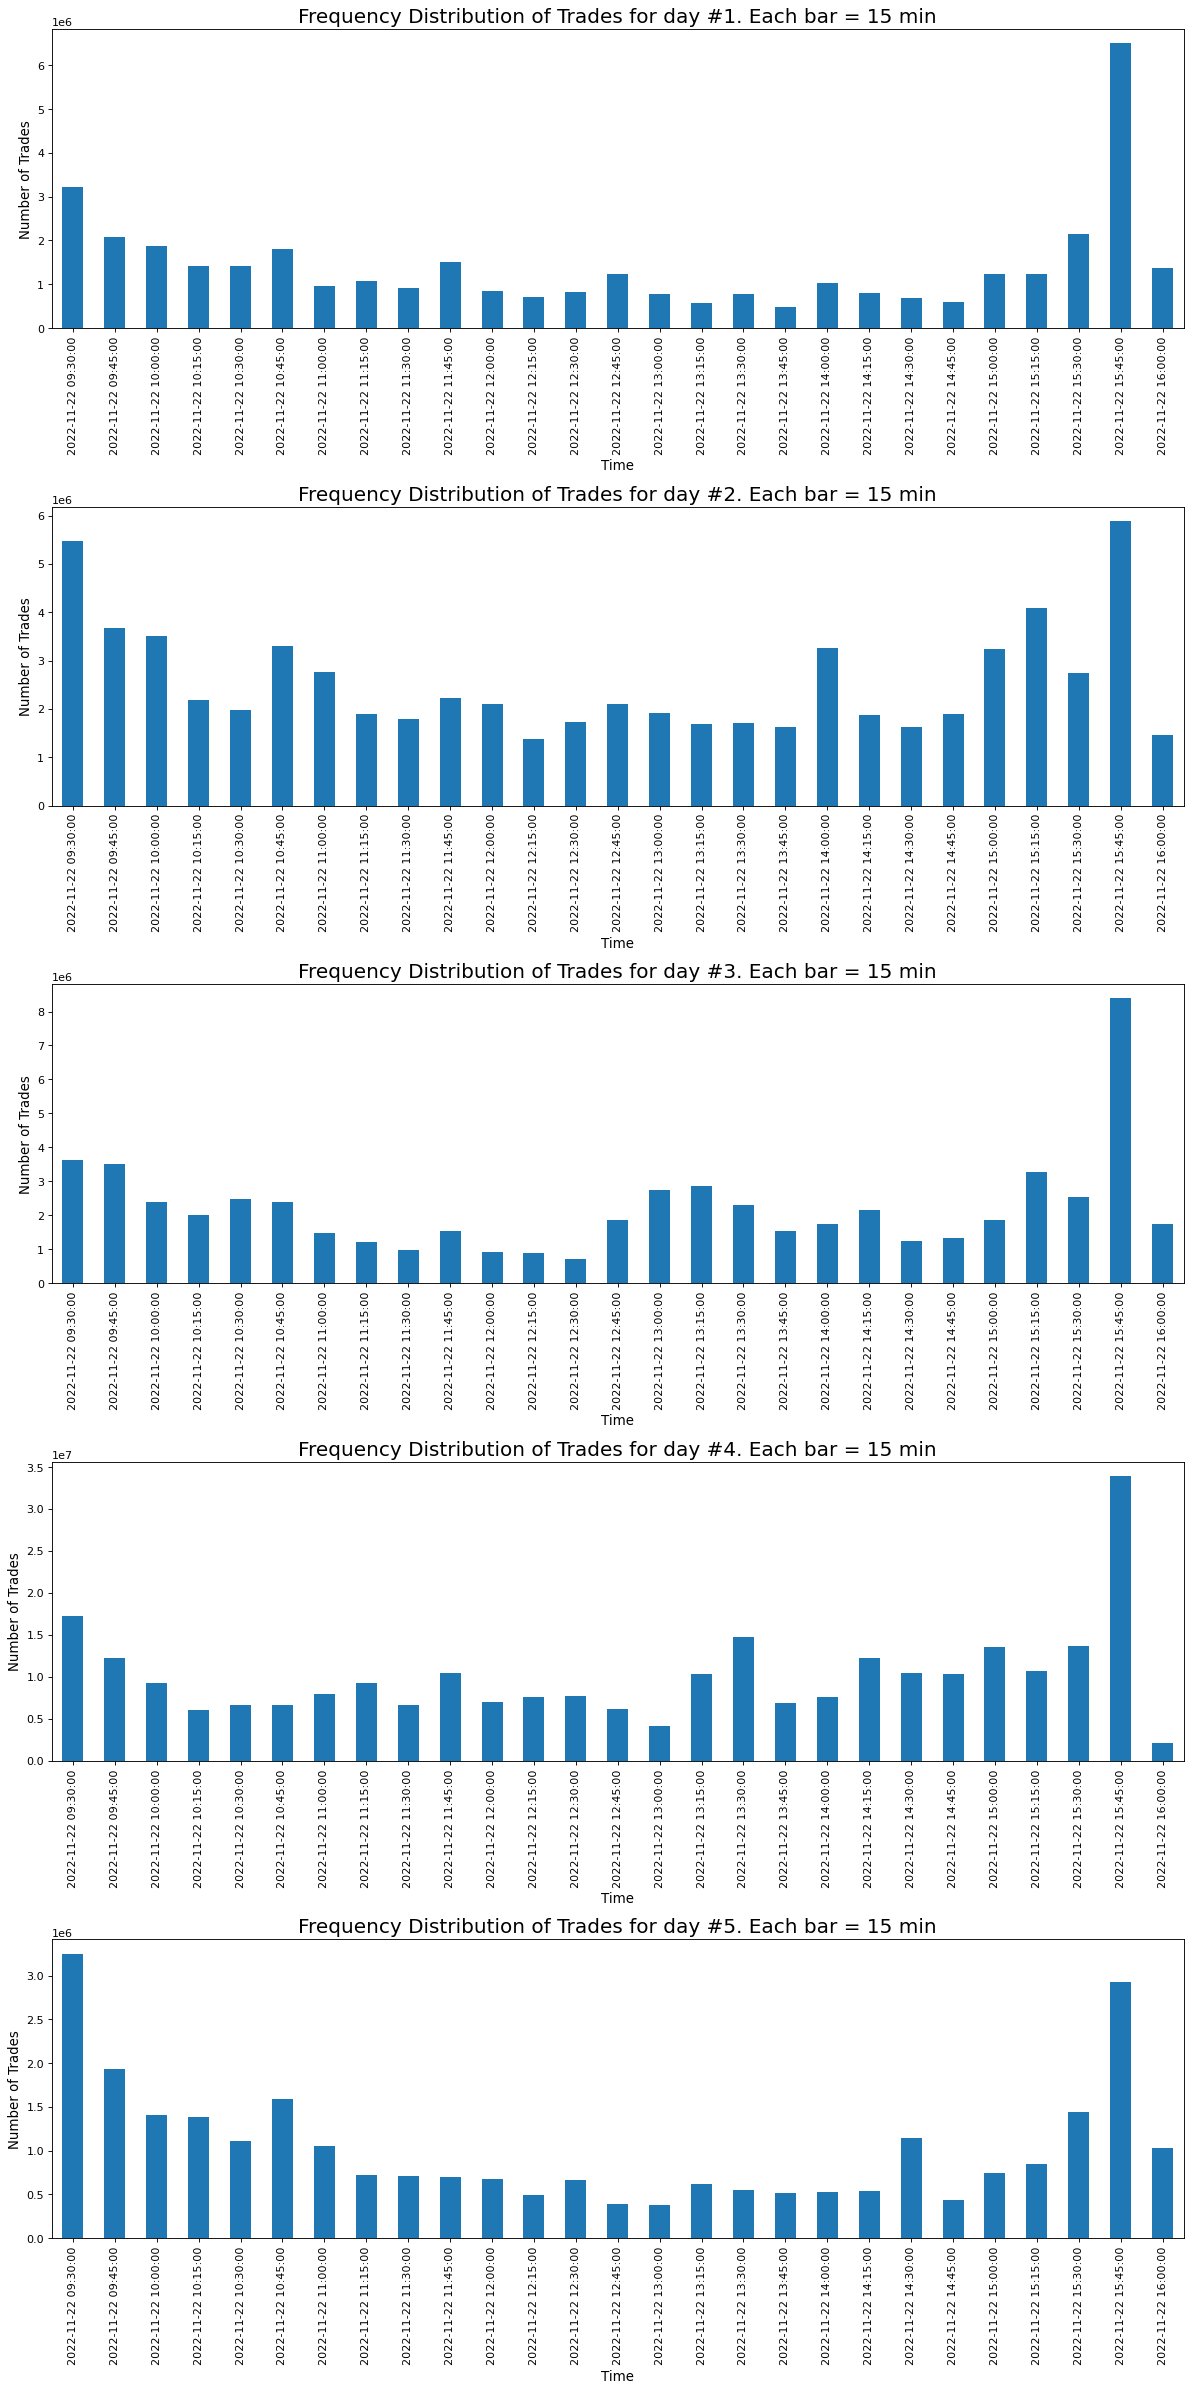

In [11]:
fig, ax = plt.subplots(5, figsize = (15, 30), dpi=80)

for i,d in enumerate(dfs,1):
    d['SIZE'].resample('15min').sum().plot(kind='bar',ax = ax[i-1])
    ax[i-1].set_title (f'Frequency Distribution of Trades for day #{i}. Each bar = 15 min', fontsize = 18)
    ax[i-1].set_xlabel ('Time', fontsize = 12)
    ax[i-1].set_ylabel ('Number of Trades', fontsize = 12)

    fig.tight_layout (pad = 1.1)

In [12]:
for i,d in enumerate(dfs,1):
    df_15min = d['SIZE'].resample('15min').sum()
    close_ = round(df_15min[(df_15min.index >= '2022-11-20 15:30:00')].sum() / df_15min.sum() *100.00 ,2)
    open_ = round(df_15min[(df_15min.index <= '2022-11-20 09:30:00')].sum() / df_15min.sum() *100.00 ,2)
    print(f'Day{i}, Open: {open_: 6}% Close:{close_: 5}%')

Day1, Open:    0.0% Close: 100.0%
Day2, Open:    0.0% Close: 100.0%
Day3, Open:    0.0% Close: 100.0%
Day4, Open:    0.0% Close: 100.0%
Day5, Open:    0.0% Close: 100.0%


#### INSIGHT: 
Looking at the volume curves by day we again spot similarities in days #2 and #3 when a significant portion of the total daily volume was traded from 15:45 to the close (mostly by institutional investors).Days #1 and #5, however, show increased volume immediately after opening of the markets from 9:30 to 9:45-10:00. As far as I know, placing orders at the beginning of the day have historically been attributed to retail investors, and fairly recently (2021) there was a trend that the sheer volume of retail orders at the opening was reversing the concentration of volume. Seeing that pattern on days #1 and #5 may indicate that those days represent more recent activity compared to days 2 and 3.

Distribution of trades throughout the day on day #4 does not look unusual, however, the volume is approximately 10 times higher than on any other day.

### 6. Number of trades recorded on day #4 is much higher compared to other days (assumption #1.3)
#### 6.1 Visualizing much higher number of trades  recorded on day #4

Text(0.5, 1.0, 'Number of trades by day')

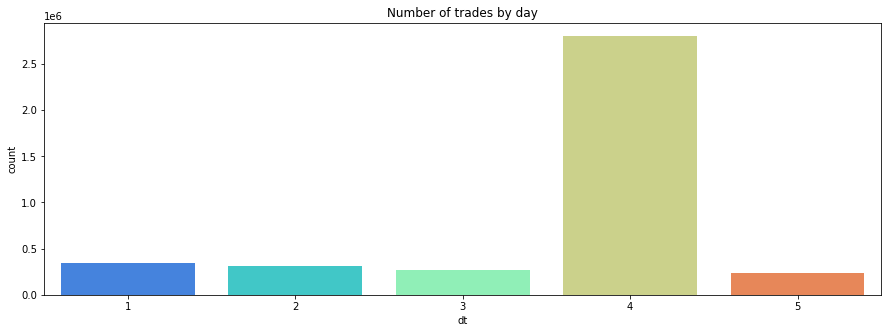

In [13]:
# visualizing difference in the number of trades recorded on day #4.
plt.figure(figsize=(15,5))
sns.countplot(data=df, x = "dt", palette='rainbow')
plt.title(f"Number of trades by day")

#### 6.2 Plotting number of trades by exchange

[Text(0.5, 1.0, 'Number of Trades by Exchange on day 4')]

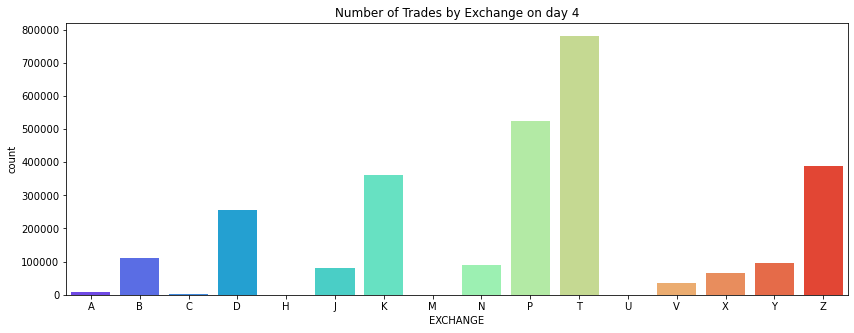

In [14]:
plt.figure(figsize=(14,5))
sns.countplot(
    data=df[df['dt']==4],
    x = "EXCHANGE",
    palette='rainbow').set(title=f'Number of Trades by Exchange on day 4')

#### Most of the trades were recorded on exchanges T, P, Z, K, an D which is similar to the pattern seen on days 2 and 3, so nothing unusual here.

#### 6.3 Plotting AVG Size by Exchange

[Text(0.5, 1.0, 'AVG Size by Exchange on day 4')]

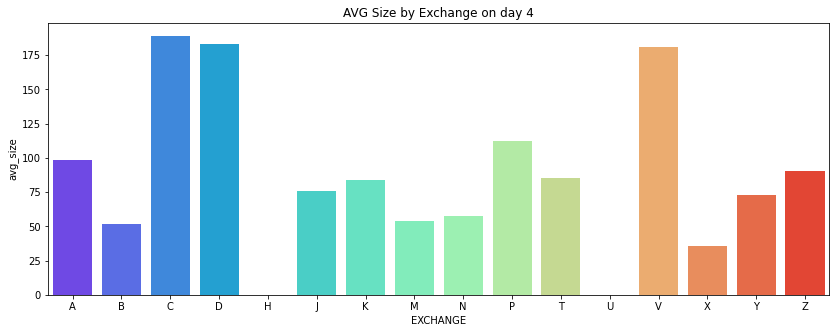

In [15]:
plt.figure(figsize=(14,5))
sns.barplot(
    data=df_by_ex[df_by_ex['dt']==4],
    x = "EXCHANGE",
    y = 'avg_size',
    palette='rainbow').set(title=f'AVG Size by Exchange on day 4')

##### Average size of the trade does not look unusual

#### 6.4 Plotting distribution of prices by exchange

Text(0.5, 1.0, 'Price by Exchange, day 4')

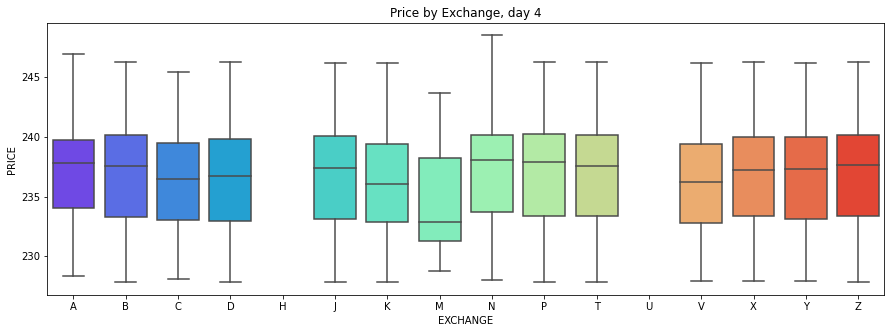

In [16]:
plt.figure(figsize=(15,5))
sns.boxplot(x='EXCHANGE',y='PRICE',data=df[df['dt']==4], palette='rainbow')
plt.title(f"Price by Exchange, day 4")

#### Prices do not look unusual

#### 6.5 Resampling the data in 2min intervals to zoom in

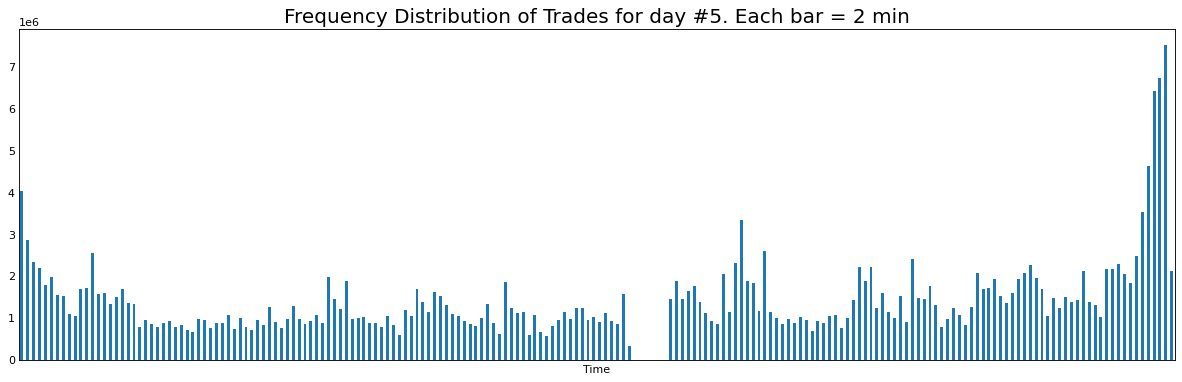

In [17]:
fig, ax = plt.subplots(1, figsize = (15, 5), dpi=80)


df4['SIZE'].resample('2min').sum().plot(kind='bar',ax = ax)
ax.set_title (f'Frequency Distribution of Trades for day #{i}. Each bar = 2 min', fontsize = 18)

plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

fig.tight_layout (pad = 1.5) # To provide space between plots

##### There is a visible gap with no data in the middle of the distribution. Let's narrow down the period when the data is missing 

In [18]:
#resample the dataframe by minute and use the total number of transactions as a metric of interest
df4_by_min = df4['SIZE'].resample('1min').agg({'size':np.sum})
# identify the gap as a period of time (minute in this case) when zero transactions were recorded
gap = df4_by_min['size'] == 0
#filter the dataframe to only display minutes within the gap
df4_by_min[gap]

,size
Time,
2022-11-22 12:57:00,0
2022-11-22 12:58:00,0
2022-11-22 12:59:00,0
2022-11-22 13:00:00,0
2022-11-22 13:01:00,0
2022-11-22 13:02:00,0
2022-11-22 13:03:00,0
2022-11-22 13:04:00,0
2022-11-22 13:05:00,0


In [19]:
gap_start = pd.to_datetime(df4_by_min[gap].index).time.min()
print(f'The gap in the data started at {gap_start} and lasted for {len(df4_by_min[gap])} min')

The gap in the data started at 12:57:00 and lasted for 14 min


#### INSIGHTS:
Number of trades recorded on day 4 was approximately 10 times higher compared to any other day. The distribution of trading volume by exchanges, average size of the trade, and average price do not look unusual. However, there was a 14-minute-long period from 12:57 until 13:11 when the trading stopped on all exchanges.

### 7. Other Plots - optional

##### Too many data points to use strip plot in a meaningful way, however, we could still use them to uncover some insigths. Below we could see a massive difference in transaction time (difference between participant time and exchange time) on exchange D, since it takes significantly longer.

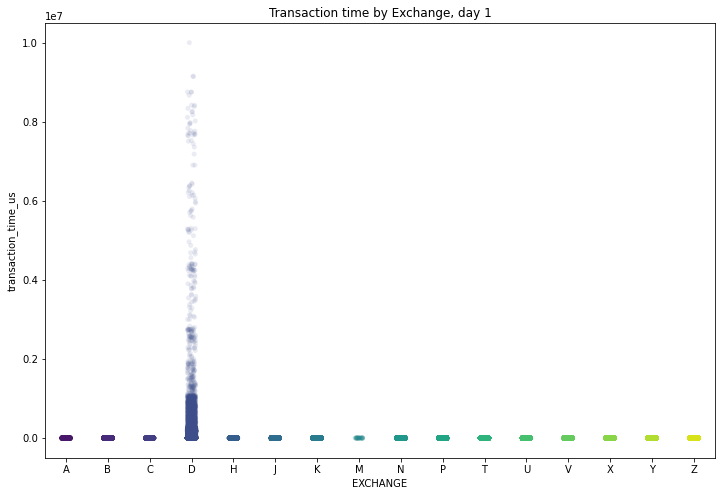

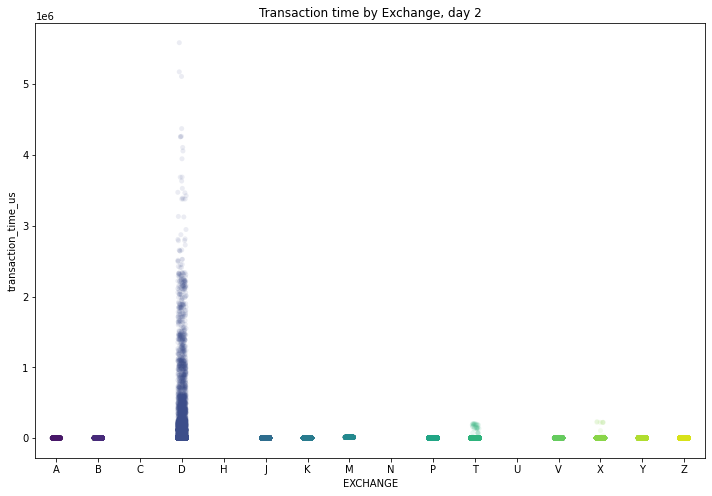

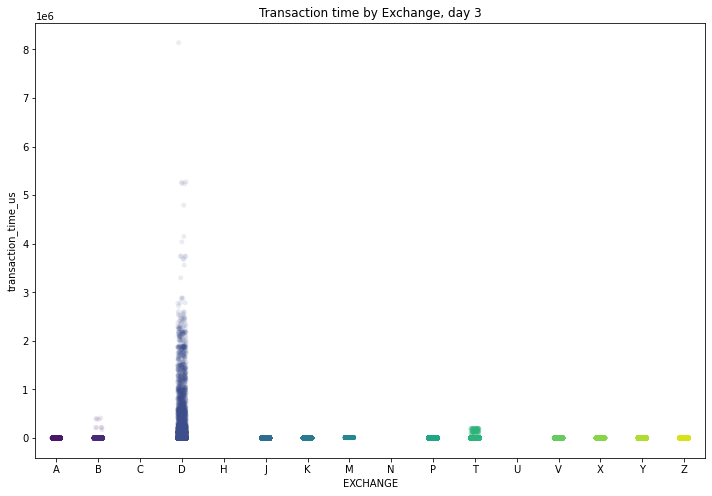

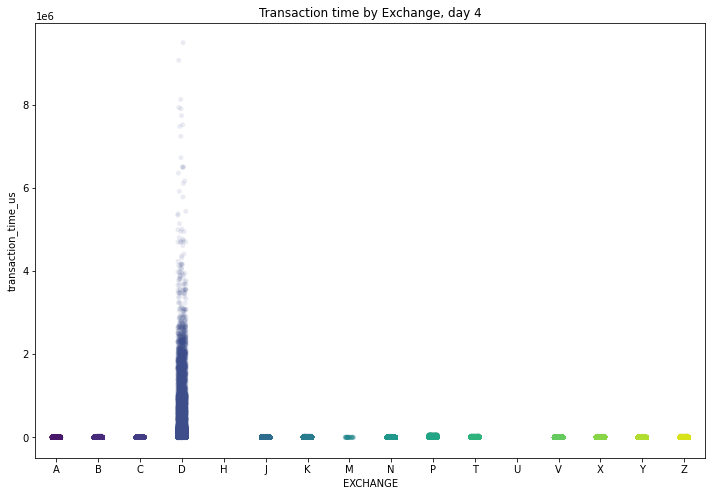

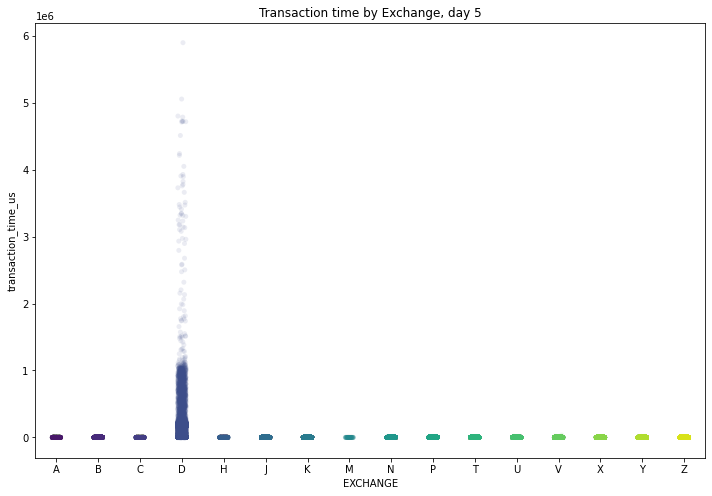

In [20]:
for dt in range(1,6):
    plt.figure(figsize=(12,8))
    sns.stripplot(x='EXCHANGE', y='transaction_time_us', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis', alpha=.1)
    plt.title(f"Transaction time by Exchange, day {dt}")
#     sns.stripplot(x='EXCHANGE', y='SIZE', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis',alpha=.1)
#     plt.title(f"Trade volume by Exchange, day {dt}")
#     sns.stripplot(x='EXCHANGE', y='PRICE', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis',alpha=.1)
#     plt.title(f"Price by Exchange, day {dt}")

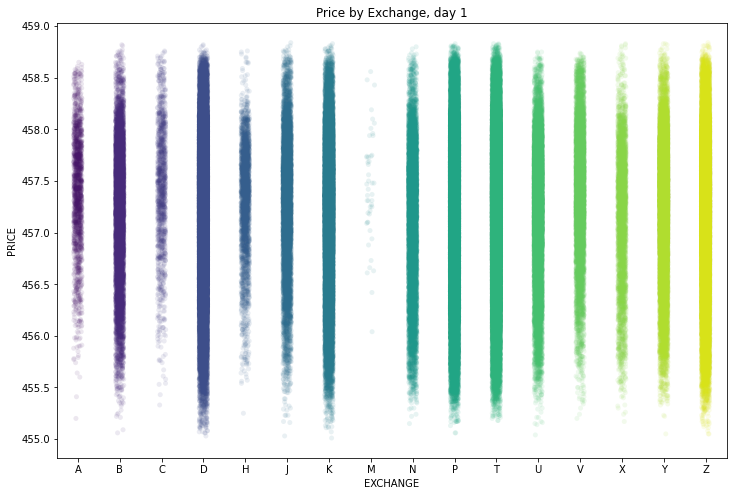

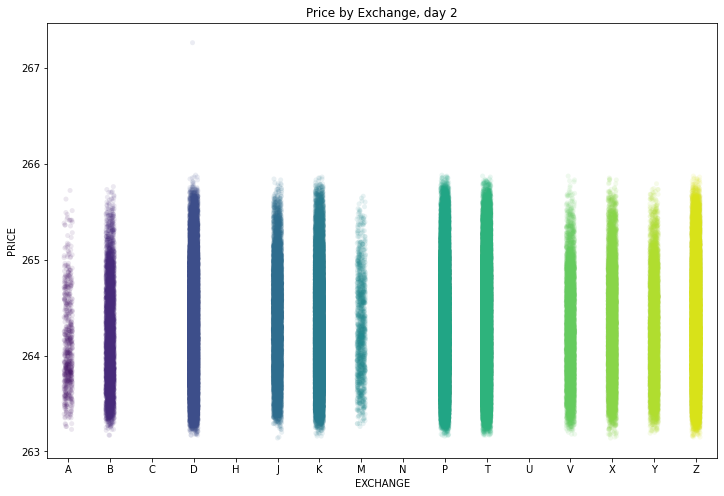

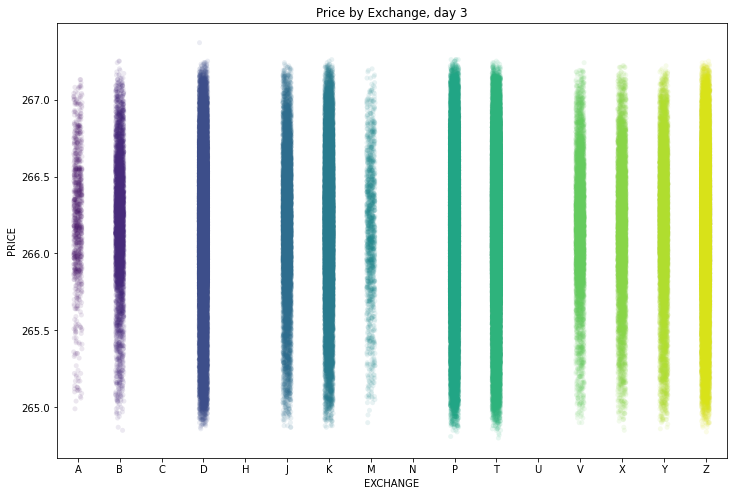

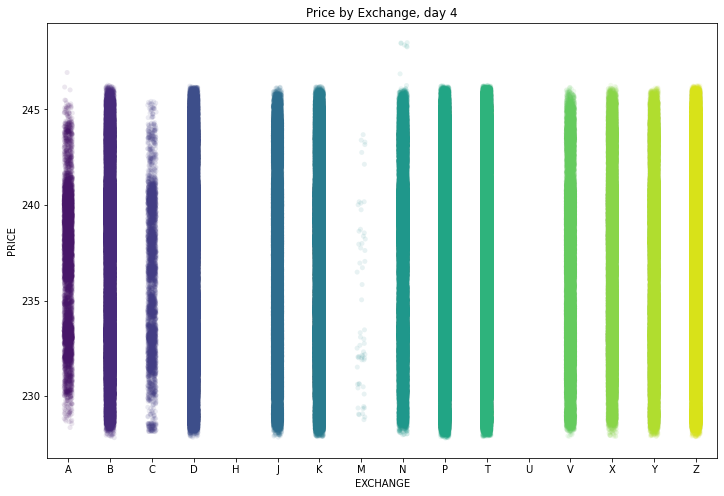

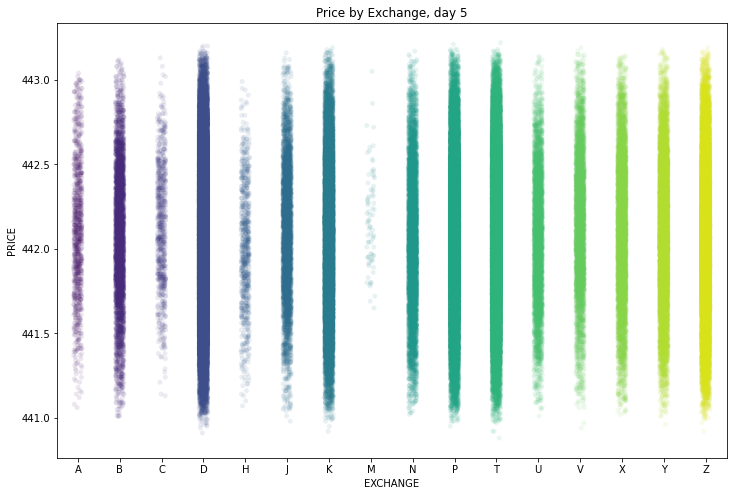

In [21]:
# striplot does not show much because of the high number of datapoints that end up overlapping with each other
for dt in range(1,6):
    plt.figure(figsize=(12,8))
#     sns.stripplot(x='EXCHANGE', y='transaction_time_us', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis', alpha=.1)
#     plt.title(f"Transaction time by Exchange, day {dt}")
#     sns.stripplot(x='EXCHANGE', y='SIZE', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis',alpha=.1)
#     plt.title(f"Trade volume by Exchange, day {dt}")
    sns.stripplot(x='EXCHANGE', y='PRICE', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis',alpha=.1)
    plt.title(f"Price by Exchange, day {dt}")

<!-- for dt in range(1,6):
    plt.figure(figsize=(12,8))
#     sns.violinplot(x='EXCHANGE', y='transaction_time_us', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis')
#     plt.title(f"Transaction time by Exchange, day {dt}")
#     sns.violinplot(x='EXCHANGE', y='SIZE', data=df[df['dt']==dt], jitter=True, dodge=True, palette='viridis')
#     plt.title(f"Trade volume by Exchange, day {dt}")
    sns.violinplot(x='EXCHANGE', y='PRICE', data=df[df['dt']==dt], dodge=True, palette='viridis')
    plt.title(f"Price by Exchange, day {dt}") -->